In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-torch/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [80]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [81]:
# img_tgt
# nca_tgt
# img_clip
# nca_clip

In [82]:
prompts = [
    # "a red apple;a green apple;a blue apple;a red apple",
    # "a skinny cat;a normal cat;a fat cat;a very very fat cat",
    # "a red apple;a green tree;a cute dog;the yellow sun",
    # "random noise;self-replicating molecules;cells floating in primordial soup;alien animals roaming around",
    
    # "a bustling luscious nature landscape",
    # "an artificial life simulation",
    # "self-replication emerging in an artificial life simulation",
    # "a photo of the emergence of open-ended complexity",


    
]

In [83]:
prompt = ';'.join([
        "many molecules and chemicals randomly floating around",
        "chemicals coming together to form a cell",
        "a single cell moving around",
        "a cell reproducing to create more cells",
        "many cells moving around",
        "a bustling diverse ecosystem of cells floating around",
        "many cells coming together to form a bigger cell",
        "bigger cells chasing smaller cells in predator-prey like dynamics",
    ])

In [86]:
cfg_default = dict(
    seed=0, save_dir=None, dtype='float32', device='cuda:0',
    
    img_size=64, n_layers=2, d_state=16, d_embd=32, locality=1, kernel_size=3, nonlin="GELU",
    
    init_state="point", padding_mode="zeros", dt=0.01, p_drop=0.0,
    
    rollout_steps=64, bptt_steps=16, pool_size=1024,
    
    target_img_path=None, prompt="a green tree", n_augs=1, augs="crop+pers", clip_model="clip-vit-base-patch32",
    
    coef_alignment=0., coef_softmax=0., coef_temporal=0.,
    
    bs=8, lr=1e-3, n_iters=10000, clip_grad_norm=1.
)

cfgs = []

seeds = np.arange(1)
coef_alignments_softmaxes = [(1., 0.), (.5, .5), (0., 1.)]
coef_temporals = np.logspace(-4, 1, 12)

for seed in seeds:
    for i1, (ca, cs) in enumerate(coef_alignments_softmaxes):
        for i2, ct in enumerate(coef_temporals):
            cfg = cfg_default.copy()
            cfg.update(prompt=prompt, rollout_steps=512, lr=3e-4, n_iters=160000)

            cfg.update(seed=seed, coef_alignment=ca, coef_softmax=cs, coef_temporal=ct)
            cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/cell_prompt_new_{seed=}_{i1=}_{i2=}")
            cfgs.append(cfg)


In [87]:
commands = experiment_utils.create_commands(cfgs, prefix='python nca_multi_prompt_clip.py', out_file='./experiments/main.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python nca_multi_prompt_clip.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/cell_prompt_new_seed=0_i1=0_i2=0"  --dtype="float32" --device="cuda:0" --img_size=64 --n_layers=2 --d_state=16 --d_embd=32 --locality=1 --kernel_size=3 --nonlin="GELU" --init_state="point" --padding_mode="zeros" --dt=0.01 --p_drop=0.0 --rollout_steps=512 --bptt_steps=16 --pool_size=1024 --target_img_path=None --prompt="many molecules and chemicals randomly floating around;chemicals coming together to form a cell;a single cell moving around;a cell reproducing to create more cells;many cells moving around;a bustling diverse ecosystem of cells floating around;many cells coming together to form a bigger cell;bigger cells chasing smaller cells in predator-prey like dynamics" --n_augs=1 --augs="crop+pers" --clip_model="clip-vit-base-patch32" --coef_alignment=1.0 --coef_softmax=0.0 --coef_temporal=9.999999999999999e-05  --bs=8 --lr=0.0003 --n_iters=160000 --clip_grad_norm=1.0
python

# Visualize Results

  0%|          | 0/12 [00:00<?, ?it/s]

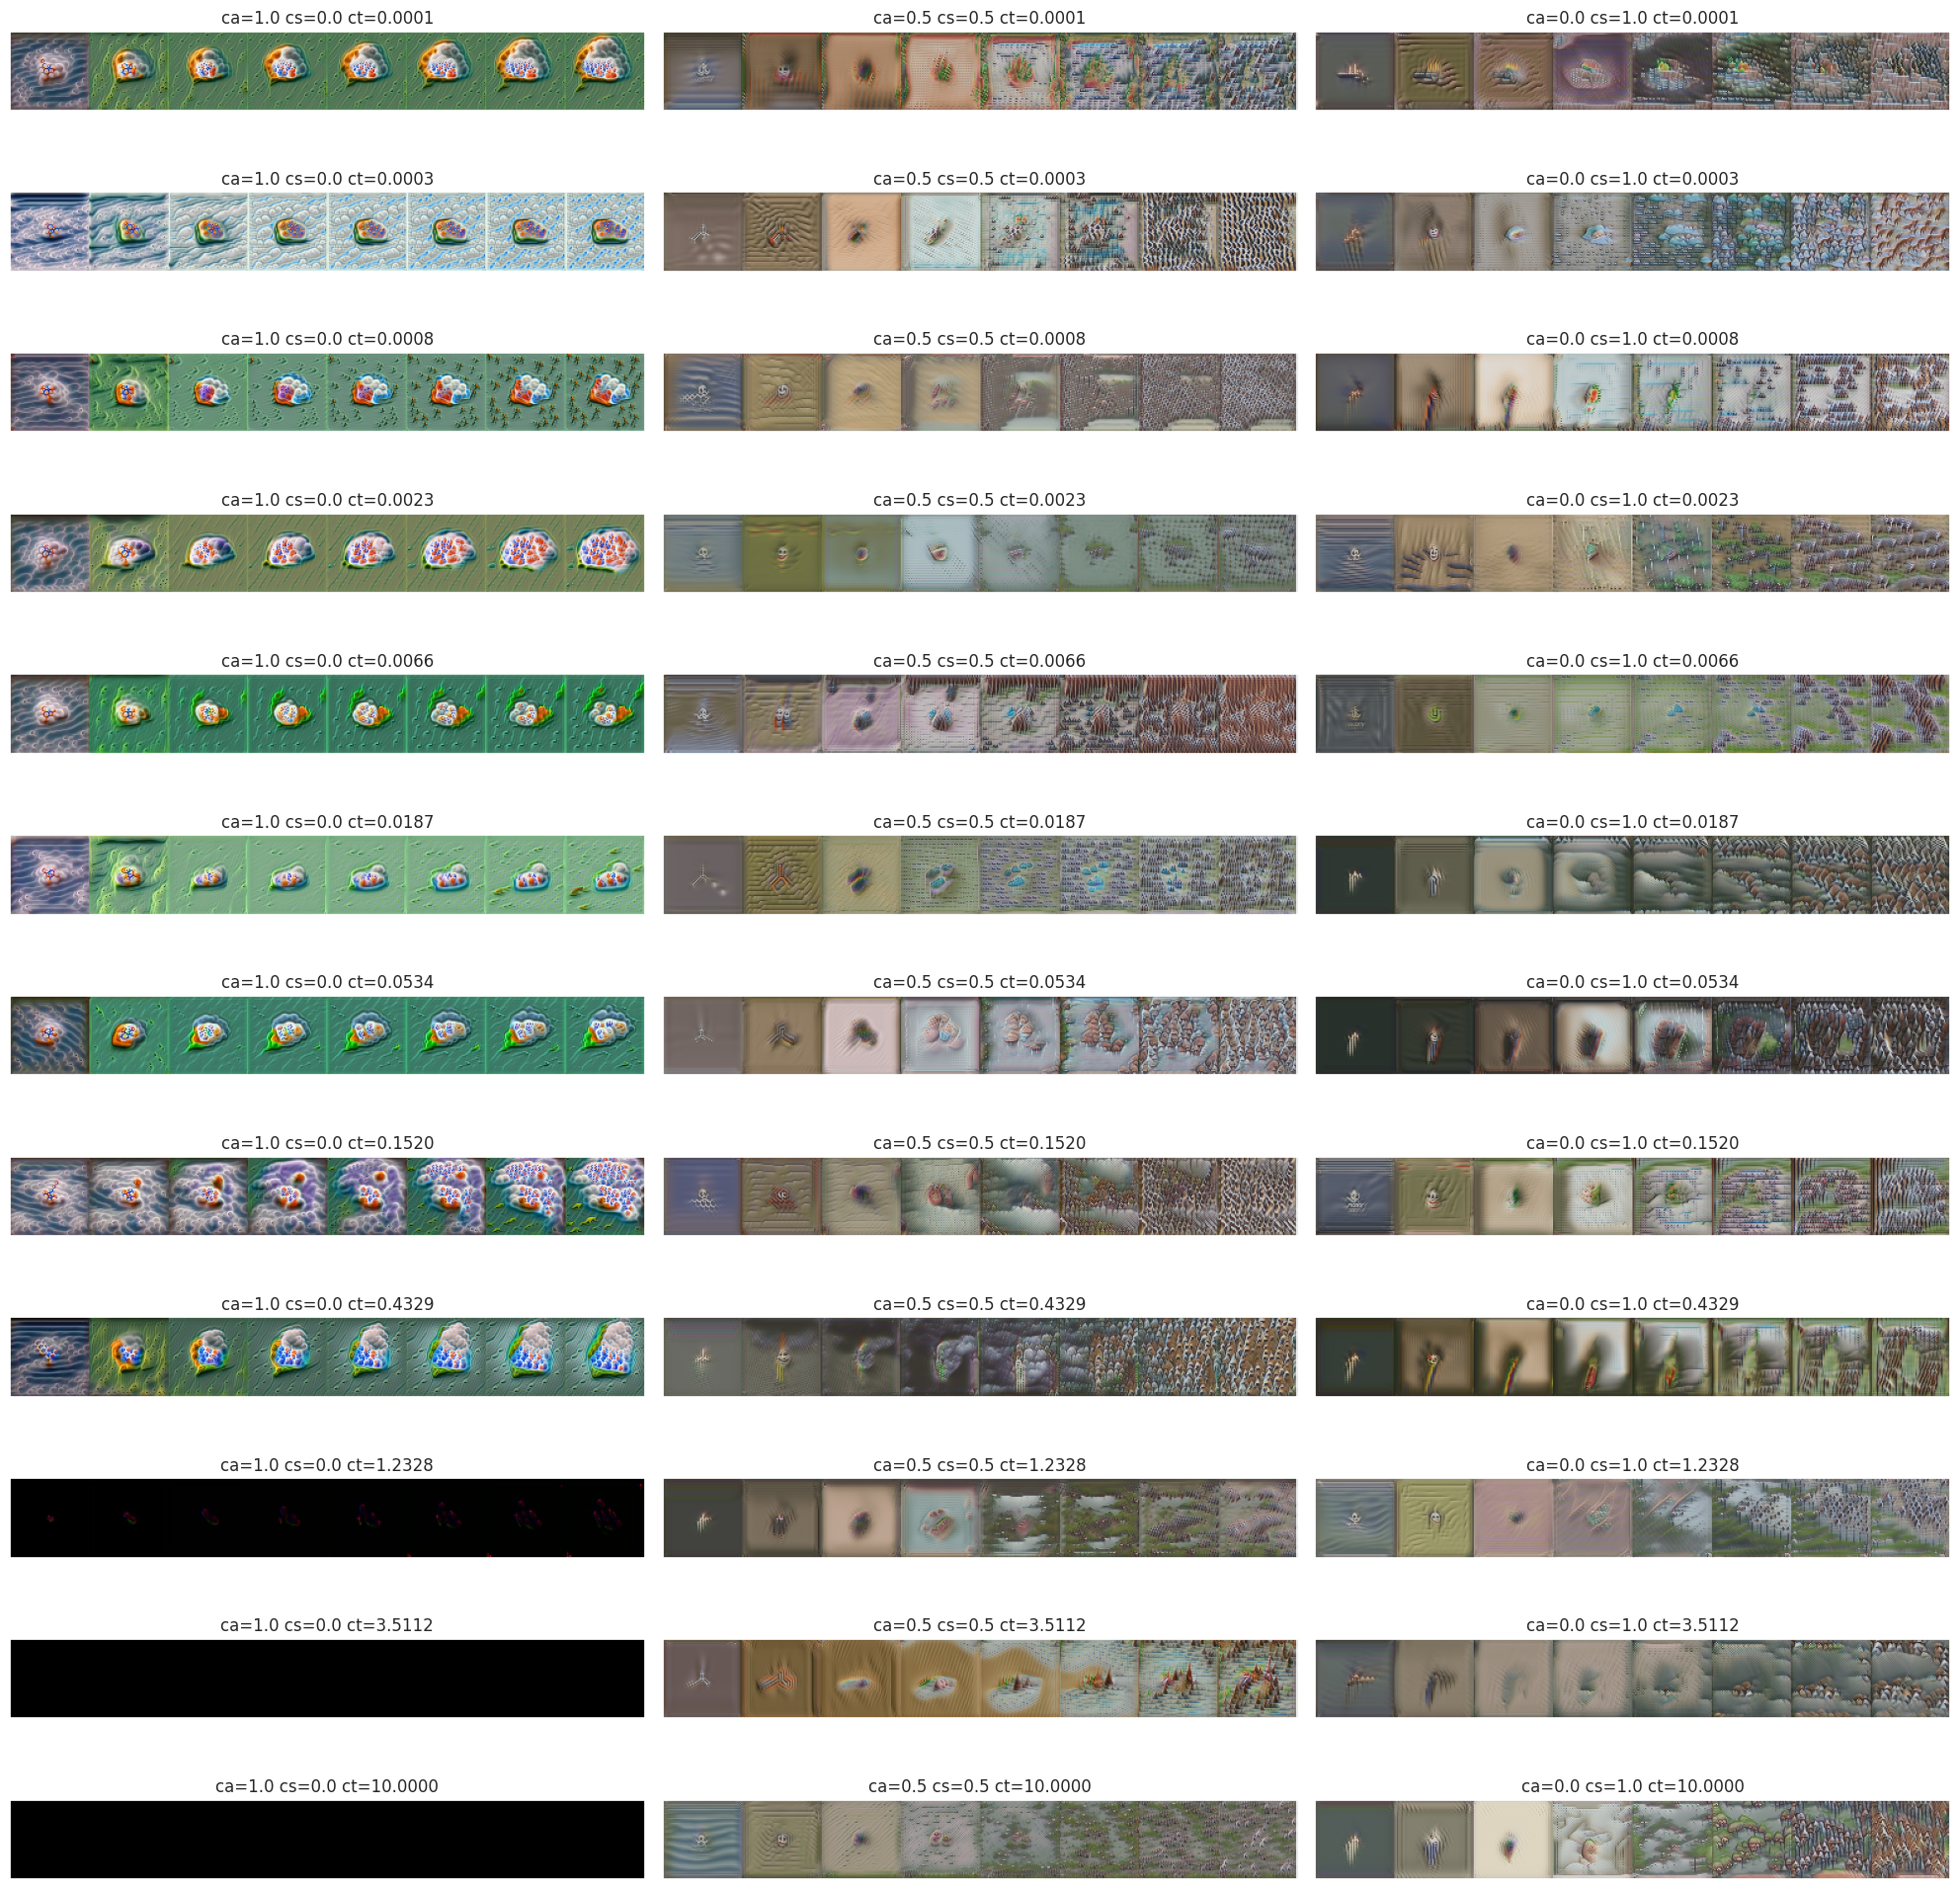

In [189]:
plt.figure(figsize=(20, 20))
iplt = 0

seed = 0
for i2, ct in enumerate(tqdm(coef_temporals)):
    for i1, (ca, cs) in enumerate(coef_alignments_softmaxes):
        save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/cell_prompt_new_{seed=}_{i1=}_{i2=}"

        vid = util.load_pkl(save_dir, "vid").astype(np.float32)

        iplt += 1
        plt.subplot(12, 3, iplt)
        plt.imshow(rearrange(vid[:1, 32::64], 'B T H W D -> (B H) (T W) D'))
        plt.title(f'{ca=} {cs=} {ct=:03.4f}')
        plt.grid(False)
        plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

In [190]:
prompt.split(';')

['many molecules and chemicals randomly floating around',
 'chemicals coming together to form a cell',
 'a single cell moving around',
 'a cell reproducing to create more cells',
 'many cells moving around',
 'a bustling diverse ecosystem of cells floating around',
 'many cells coming together to form a bigger cell',
 'bigger cells chasing smaller cells in predator-prey like dynamics']

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

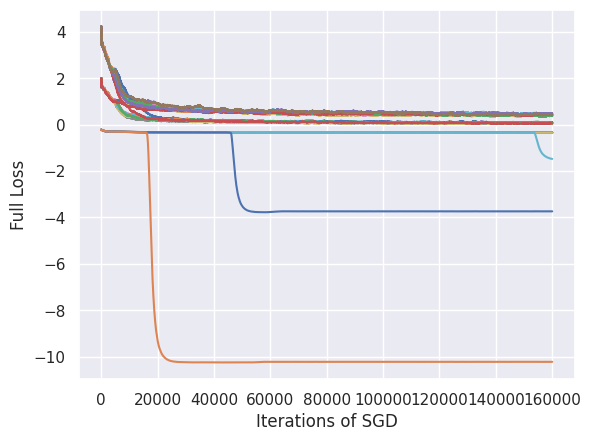

In [195]:
seed = 0
for i1, (ca, cs) in enumerate(coef_alignments_softmaxes):
    for i2, ct in enumerate(tqdm(coef_temporals)):
        save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/cell_prompt_new_{seed=}_{i1=}_{i2=}"
        losses = util.load_pkl(save_dir, "losses")
        plt.plot(pd.DataFrame(losses['loss']).ewm(span=1000).mean())

plt.xlabel('Iterations of SGD')
plt.ylabel('Full Loss')
plt.show()

In [196]:
df = []
seed = 0
for i1, (ca, cs) in enumerate(coef_alignments_softmaxes):
    for i2, ct in enumerate(tqdm(coef_temporals)):
        save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/cell_prompt_new_{seed=}_{i1=}_{i2=}"
        losses = util.load_pkl(save_dir, "losses")
        dfi = {k: v[-40000:].mean() for k, v in losses.items()}
        dfi.update(coef_alignment=ca, coef_softmax=cs, coef_temporal=ct)
        df.append(dfi)
df = pd.DataFrame(df)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

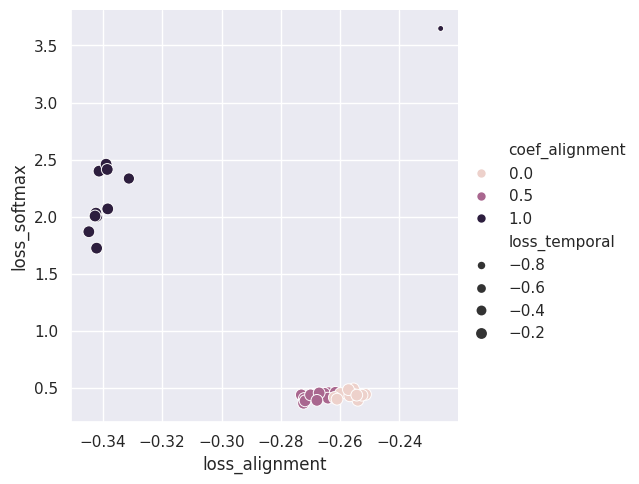

In [197]:
g = sns.relplot(data=df, x='loss_alignment', y='loss_softmax', size='loss_temporal', hue='coef_alignment', kind='scatter')
# g.set(xscale="log")

In [166]:
df['loss_temporal']

0    -0.000098
1    -0.000362
2    -0.000148
3    -0.000144
4    -0.000124
5    -0.000175
6    -0.000112
7    -0.000149
8    -0.000215
9    -0.125882
10   -0.999999
11   -0.999999
12   -0.000075
13   -0.000099
14   -0.000045
15   -0.000036
16   -0.000070
17   -0.000058
18   -0.000054
19   -0.000052
20   -0.000059
21   -0.000038
22   -0.000072
23   -0.000065
24   -0.000065
25   -0.000079
26   -0.000093
27   -0.000043
28   -0.000055
29   -0.000087
30   -0.000071
31   -0.000087
32   -0.000093
33   -0.000050
34   -0.000067
35   -0.000098
Name: loss_temporal, dtype: float32

In [174]:
seed = 0
for i1, (ca, cs) in enumerate(coef_alignments_softmaxes):
    for i2, ct in enumerate(tqdm(coef_temporals)):
        save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/cell_prompt_new_{seed=}_{i1=}_{i2=}"

        vid = util.load_pkl(save_dir, "vid").astype(np.float32)

        # plt.figure(figsize=(10, 3))
        # plt.imshow(rearrange(vid[:1, 32::64], 'B T H W D -> (B H) (T W) D'))
        # plt.title(f'{ca=} {cs=} {ct=}')
        # plt.grid(False)
        # plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [176]:
vid.shape

(8, 512, 64, 64, 3)

In [181]:
save_as_gif(vid[0, ::1], "./vid.gif")

  0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_2560898/2374773225.py:18: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


In [175]:
from PIL import Image
def save_as_gif(data, file_path):
    """
    Saves a NumPy array (T, H, W, 3) as an animated GIF.
    Args:
    data (np.array): A NumPy array with shape (T, H, W, 3) representing RGB images.
    file_path (str): The file path where the GIF should be saved.
    """
    images = []

    for i in tqdm(range(data.shape[0])):
        fig, ax = plt.subplots()
        ax.imshow(data[i], interpolation='none')
        ax.axis('off')  # Hide axes

        # Save plot to a PIL Image object
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(Image.fromarray(image))

        plt.close(fig)

    # Save images as a GIF
    images[0].save(file_path, save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)